# SD212: Graph mining
## Lab 6: Clustering

You will learn how to cluster the nodes of a graph and to estimate the quality of the clustering. 

You **must** be connected to Telecom ParisTech network!

## Getting started

In [21]:
from connector import Connector

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
base_url = 'http://137.194.192.13:8234'
lab_id = 'lab6'

## To do

* Enter your login and test it using question #0

In [24]:
# Enter your login (last name followed by first letter of first name)
login = 'zhuf'

In [25]:
connector = Connector(base_url, lab_id, login)
get_question = connector.get_question
post_answer = connector.post_answer
post_text = connector.post_text

In [26]:
get_question(0)

Welcome!


## Import

In [27]:
import networkx as nx

The documentation is available [here](https://networkx.readthedocs.io/en/stable/).

In [28]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [29]:
import numpy as np

In [30]:
colors = ['b','g','r','c','m','gold','orange','gray','k','w']

## 1. Modularity

Consider an undirected, unweighted graph of $n$ nodes and $m$ edges with adjacency matrix $A$, without self-loops.

The modularity of clustering $C$ is defined by:
$$
Q(C) = \frac 1 {2m} \sum_{i,j\in V} \left(A_{ij} - \frac {d_id_j}{2m}\right) \delta_{C(i),C(j)}
$$
where $d_i = \sum_j A_{ij}$ is the degree of node $i$.

## Toy graph

Consider the following graph:

In [125]:
edgelist = [(7,5),(5,3),(3,7),(4,5),(8,6),(7,4),(1,6),(9,8),(7,8),(6,1),(2,9),(8,2),(1,9)]
G = nx.Graph()
G.add_edges_from(edgelist)

Consider the following clustering:

In [126]:
C = {1: 0, 2: 0, 6: 0, 8: 0, 9: 0, 3: 1, 4: 1, 5: 1, 7: 1}

<IPython.core.display.Javascript object>


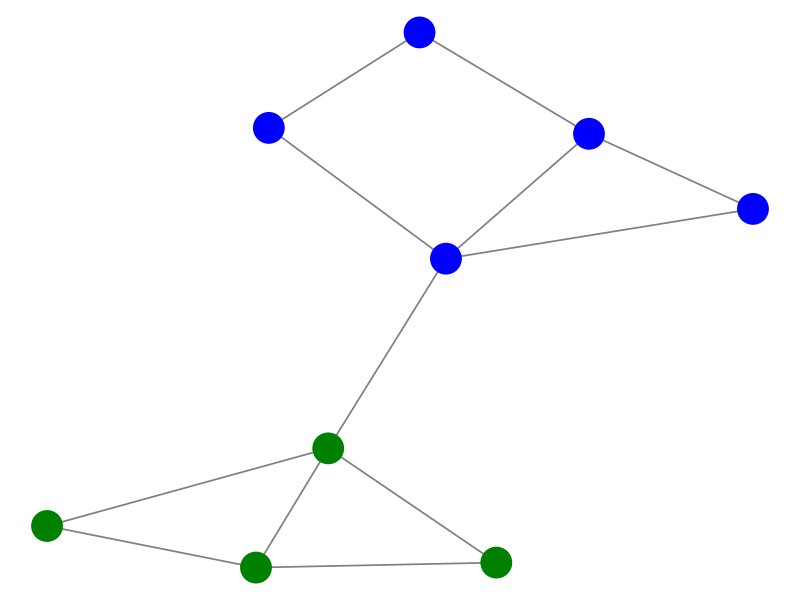

In [127]:
figure()
node_color = [colors[C[u] % len(colors)] for u in G.nodes()]
nx.draw(G,node_color = node_color,edge_color = 'gray')

## To do

* Answer questions #1, #2, #3 **(0.5 point)**
* Answer question #4 **(open answer)**
* Complete the function `modularity` below and check it on the above graph

In [137]:
get_question(1)

What is the fraction of edges within clusters?
(Enter a float)


In [138]:
answer = 11/12
print(answer)

0.9166666666666666


In [139]:
post_answer(1,answer)

This is correct!


In [140]:
get_question(2)

What is the Simpson index associated with this clustering?
(Enter a float; remember that nodes are sampled in proportion to their degrees)


In [141]:
answer = (11/24)**2 + (13/24)**2
print(answer)

0.5034722222222221


In [142]:
post_answer(2,answer)

This is correct!


In [143]:
get_question(3)

What is the modularity of this clustering?
(Enter a float)


In [144]:
answer = 0.9166666666666666 - 0.5034722222222221
answer

0.41319444444444453

In [204]:
post_answer(3,answer)

Wrong answer


In [146]:
get_question(4)

Comment the results.


In [147]:
post_text(4)

Textarea(value='...')

Button(description='Send', style=ButtonStyle())

In [225]:
def modularity(G,C):
    # G: networkx graph
    # C: clustering (dictionary)
    # Returns: Q, modularity (at resolution 1)
    m = G.number_of_edges()
    w = sum(list(dict(G.degree()).values()))
    Q = 0
    cluster = dict()
    for _node,_class in C.items():
        if(_class not in cluster):
            cluster[_class] = set([_node])
        else:
            cluster[_class].add(_node)
    
    item1 = 0.0
    item2 = 0.0
    for _class, _nodes in cluster.items():
        subG = nx.subgraph(G,_nodes)
        mk = subG.number_of_edges()
        wk = np.array(list(dict(G.degree(_nodes)).values()), dtype = float).sum()
        item1 = item1 + mk/m
        item2 = item2 + (wk/w)**2
    Q = item1 - item2
    # to be completed
    return Q

In [210]:
modularity(G,C)

0.41319444444444464

## Stochastic block model

In [222]:
block_sizes = [10, 20, 30]
G = nx.random_partition_graph(sizes = block_sizes, p_in = 0.3, p_out = 0.03,seed = 0)
pos = nx.spring_layout(G)

<IPython.core.display.Javascript object>


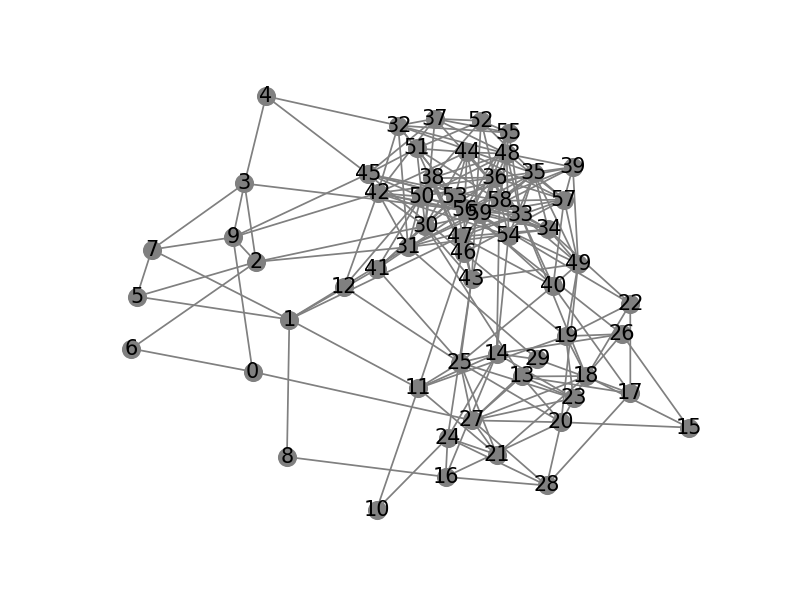

In [223]:
figure()
axis('off')
nx.draw(G, pos,node_color = 'gray',edge_color = 'gray',node_size = 100, with_labels = True)

## To do

* Answer question #5 **(0.5 point)**

In [213]:
get_question(5)

What is the modularity of the ground-truth clustering (given by the blocks)?
(Enter a float)


In [224]:
C1 = {x:0 for x in range(0,10)}
C2 = {x:1 for x in range(10,30)}
C3 = {x:2 for x in range(30,60)}
C1.update(C2)
C1.update(C3)

In [226]:
modularity(G, C1)

0.3618235570522359

In [227]:
answer = 0.3618235570522359

In [228]:
post_answer(5,answer)

This is correct!


## 2. The Louvain algorithm

The Louvain algorithm attempts to maximize modularity as follows:
1. **(Initialization)** $C \gets \text{identity}$ 
2.  **(Maximization)** While modularity increases, update $C$ by moving one node  from its cluster to one of its neighbors
3. **(Aggregation)** Merge all nodes belonging to the same cluster into a single node, update the weights accordingly and apply step 2 to the  aggregate graph

In step 2, nodes are considered in a cyclic way. The target cluster of a node is chosen among those of its neighbors as that providing the **largest gain** in modularity, if any.

## To do

* Complete the function `maximize` corresponding to step 2; your function must take the resolution parameter $\gamma$ into account
* Test your `louvain` function on the toy graph and the stochastic block model
* Answer question #6 **(0.5 point)**
* Answer question #7 **(open answer)**

In [ ]:
def maximize(G, gamma):
    # G: networkx graph (undirected, weighted)
    # gamma: float (resolution)
    # Returns: dictionary (cluster of each node)
    
    # node weights
    node_weight = {u: 0 for u in G.nodes()}
    # sum of edge weights
    w = 0
    for (u,v) in G.edges():
        # self-loops are counted twice
        node_weight[u] += G[u][v]['weight']
        node_weight[v] += G[u][v]['weight']
        w += G[u][v]['weight']
    # init the clustering
    C = {u:u for u in G.nodes()}
    # cluster weights
    cluster_weight = {u:node_weight[u] for u in G.nodes()}
    # node-cluster weights 
    node_cluster_weight = {u:{v:G[u][v]['weight'] for v in G.neighbors(u) if v != u} for u in G.nodes()}
    increase = True
    while increase:
        increase = False
        for u in G.nodes():
            k = C[u]
            
            # target cluster, to be modified
            l = C[u]
            
            if l != k:
                increase = True
                # move u from cluster k to cluster l
                C[u] = l
                cluster_weight[k] -= node_weight[u]
                cluster_weight[l] += node_weight[u]
                for v in G.neighbors(u):
                    if v != u:
                        node_cluster_weight[v][k] -= G[u][v]['weight']
                        if node_cluster_weight[v][k] <= 0:
                            node_cluster_weight[v].pop(k)
                        if l not in node_cluster_weight[v]:
                            node_cluster_weight[v][l] = 0
                        node_cluster_weight[v][l] += G[u][v]['weight']
    return C

In [ ]:
def aggregate(G,C):
    # G: networkx graph
    # C: dictionary (clustering)
    # Returns: networkx graph (aggregate graph)
    H = nx.Graph()
    for (u,v) in G.edges():
        if H.has_edge(C[u],C[v]):
            H[C[u]][C[v]]['weight'] += G[u][v]['weight']
        else:
            H.add_edge(C[u],C[v])
            H[C[u]][C[v]]['weight'] = G[u][v]['weight']
    return H

In [ ]:
def louvain(G,gamma = 1):
    # G: networkx graph (undirected, weighted)
    # gamma: float (resolution)
    # Returns a dictionary (cluster of each node)
    if nx.get_edge_attributes(G,'weight') == {}:
        for (u,v) in G.edges():
            G[u][v]['weight'] = 1
    C = maximize(G, gamma)
    n = len(C)
    k = len(set(C.values()))
    while k < n:
        H = aggregate(G,C) 
        C_new = maximize(H, gamma)
        C = {u: C_new[C[u]] for u in G.nodes()}
        n = k
        k = len(set(C.values()))
    # reindex cluster values
    cluster_values = list(set(C.values()))
    reindex = {c:i for i,c in enumerate(cluster_values)}
    C = {u:reindex[C[u]] for u in C}
    return C

In [229]:
get_question(6)

How many clusters are found by the Louvain algorithm at resolution 1 on the stochastic block model considered above?
(Enter an integer)


In [ ]:
answer = -1

In [ ]:
post_answer(6,answer)

In [ ]:
get_question(7)

In [ ]:
post_text(7)

## Real datasets

We now consider the following real datasets, to be downloaded [here](http://perso.telecom-paristech.fr/~bonald/graphs/lab6.zip):
* the graph of [Les Misérables](https://fr.wikipedia.org/wiki/Les_Misérables) (co-occurence of characters in chapters of the novel of Victor Hugo)
* the graph of [OpenFlights](https://openflights.org) (number of daily flights between airports)
* the graph of [Wikipedia for Schools](https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_for_Schools) (links between a selection of articles from Wikipedia)

## To do

* Draw the graphs of Les Misérables and OpenFlights with the clustering found by Louvain at different resolutions
* Answer question #8 **(0.5 point)**
* List the top-10 nodes (in degree) of the top-10 clusters (in size) of Wikipedia for Schools at resolution 10

In [ ]:
G = nx.read_graphml("miserables.graphml", node_type = int)
names = nx.get_node_attributes(G, 'name')
pos = nx.spring_layout(G)

In [ ]:
C = louvain(G,gamma = 1)

In [ ]:
figure()
node_color = [colors[C[u] % len(colors)] for u in G.nodes()]
nx.draw(G, pos, labels = names, font_size = 8, node_size = 100, edge_color = 'gray',node_color = node_color)

In [ ]:
G = nx.read_graphml("openflights.graphml", node_type = int)
# Get names
names = nx.get_node_attributes(G, 'name')
# Get positions
pos_x = nx.get_node_attributes(G,'pos_x')
pos_y = nx.get_node_attributes(G,'pos_y')
pos = {u: (pos_x[u], pos_y[u]) for u in G.nodes()}

In [ ]:
C = louvain(G, gamma = 1)

In [ ]:
figure(figsize=(10,5))
axis('off')
node_color = [colors[C[u] % len(colors)] for u in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size = 10, node_color = node_color)
edges = nx.draw_networkx_edges(G, pos, alpha = .1)

In [ ]:
get_question(8)

In [ ]:
answer = -1

In [ ]:
post_answer(8,answer)

In [ ]:
G = nx.read_graphml("wikipedia-schools-undirected.graphml", node_type = int)
names = nx.get_node_attributes(G, 'name')

In [ ]:
C = louvain(G, gamma = 10)

## 3. Cluster ranking

The strength of cluster $k$ is defined by:
$$
\sigma_k = \frac{2w_k^{(E)}}{w_k^{(V)}}
$$
where 
* $w^{(E)}_k$  is the total weight of edges  in cluster $k$ 
* $w^{(V)}_k$  is the total weight of nodes in cluster $k$

## To do

* Complete the function `cluster_strength` that returns the strength of each cluster
* Answer questions #9 and #10 **(1 point)**

In [ ]:
def cluster_strength(G,C):
    # G: networkx graph
    # C: dictionary (clustering)
    # Returns a dictionary (strength of each cluster)
    strength = {}
    # to be completed
    return strength

In [ ]:
get_question(9)

In [ ]:
answer = ""

In [ ]:
post_answer(9,answer)

In [ ]:
get_question(10)

In [ ]:
answer = ""

In [ ]:
post_answer(10,answer)

In [ ]:
G = nx.read_graphml("openflights.graphml", node_type = int)
names = nx.get_node_attributes(G, 'name')

In [ ]:
G = nx.read_graphml("wikipedia-schools-undirected.graphml", node_type = int)
names = nx.get_node_attributes(G, 'name')